In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 144

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

import time
from datetime import datetime, timedelta

In [3]:
sess = None

def reset_vars():
    sess.run(tf.global_variables_initializer())

def reset_tf():
    global sess
    if sess:
        sess.close()
    tf.reset_default_graph()
    sess = tf.Session()

<!-- requirement: images/noise_0.png -->
<!-- requirement: images/noisy_image_0.png -->
<!-- requirement: images/nn-fool0.jpg -->
<!-- requirement: images/nn-fool1.jpg -->
<!-- requirement: images/negative1.png -->
<!-- requirement: images/negative2.png -->
<!-- requirement: images/subliminal-graffiti-sticker.jpg -->

# Adversarial Noise

## Fooling Neural Networks

Neural Networks are inspired by our own brains' wiring, but how close is their actual operation?  One way to judge is by looking at how they fail.  If we build an image to fool a neural network, is it also one that would fool a human?

The answer, at present, is a resounding "No".  Consider these images, generated by Nguyen, Yosinski, and Clune in a [recent paper](https://arxiv.org/abs/1412.1897).  They trained a neural network for image recognition, and then build images that the network would classify with extreme confidence.  To us, the images appear to be noise.

![fool0](images/nn-fool0.jpg)
*A neural network classifies each of these images into the class below it with confidence $\ge$ 99.6%.  From Nguyen A, Yosinski J, Clune J. Deep Neural Networks are Easily Fooled: High Confidence Predictions
for Unrecognizable Images. In Computer Vision and Pattern Recognition (CVPR ’15), IEEE, 2015.*

Perhaps this is not entirely surprising.  The net must classify the image as something, and it was not trained to recognize "noise".  Some combination of pixels ought to be able to tickle the right inputs in a way to produce a high-confidence classification.  More surprising, perhaps, are the following images, which produce equally confident classifications, despite having clear patterns and little resemblance to the objects in question.

![fool1](images/nn-fool1.jpg)
*A neural network classifies each of these images into the class below it with confidence $\ge$ 99.6%.  From Nguyen A, Yosinski J, Clune J. Deep "Neural Networks are Easily Fooled: High Confidence Predictions
for Unrecognizable Images". In Computer Vision and Pattern Recognition (CVPR ’15), IEEE, 2015.*

This suggests that the features that a neural network is triggering on are in fact significantly different from those that our brains are picking out.  

## Attacking Networks

These results, though interesting, may seem nothing more than an intellectual curiosity.  The images are clearly artificial and can easily be picked out by a human.  However, it would be more worrying if it were possible to produce images that a human would confidently classify in one category, while a neural net work confidently classify it in another.  Such an image could be used to attack a system involving a classifier without being obvious.

Researchers have managed to produce such attacks.  Starting with an arbitrary image, it is possible to make small, barely noticeable modifications that cause a neural network to change its classification of the image.  The follow examples come from a [paper](https://arxiv.org/abs/1312.6199) by Szegedy, *et al*.

![negative1](images/negative1.png)
![negative2](images/negative2.png)

*On the left, sample images correctly classified by [AlexNet](https://en.wikipedia.org/wiki/AlexNet).  On the right, distorted images that AlexNet classifies as ostriches.  The center images show the differences between the original an modified images, magnified by a factor of 10. From C. Szegedy, W. Zaremba, I. Sytskever, J. Bruna, D. Erhan, I. Goodfellow, R. Fergus, "Intriguing Properties of Neural Networks".  arXiv:1312.6199, February 2014.*

In this case, a unique noise was created for each input, but even that is unnecessary.  It is in fact possible to generate a single **adversarial noise** which can cause a neural network to misclassify most input images into whatever class the attacker desires.

In this notebook, we will build an attack against a CNN designed to classify MNIST images.  It will produce a noise that looks like the left image, where red and blue pixels represent positive and negative changes to the pixel intensities.  When added to an MNIST image (right), it will cause the CNN to classify the image as a zero.

<table>
    <tr>
        <td> <img src="files/images/noise_0.png" style="width: 400px;"/> </td>
        <td> <img src="files/images/noisy_image_0.png" style="width: 400px;"/> </td>
    </tr>
</table>

While adversarial noise is trained against a particular network, it is somewhat robust.  Noise trained on one network has been show to be able to attack a second network with the same architecture but trained independently, albeit with reduced efficiency.

Such attacks are even possible in the real world.  [Recent work](https://iotsecurity.eecs.umich.edu/#roadsigns) by Evtimov, *et al*, have produced adversarial noise in the form of stickers applied to street signs.  These can reliably cause the misclassification of those signs by a CNN.

![street sign](images/subliminal-graffiti-sticker.jpg)
*A CNN misclassifies this as a "Speed Limit 45" sign in two-thirds of trials.  From I. Evtimov, K. Eykholt, E. Fernandes, T. Kohno, B. Li, A. Prakash, A. Rahmati, D. Song, "Robust Physical-World Attacks on Machine Learning Models". arXiv:1707.08945, August 2017.*

## How do you find adversarial noise?

Before attempting to correct for the noise, we first have to find it. We'll get different noise patterns for each class (0-9), so we'll have to calculate adversarial noise 10 times. We will leave this as an exercise for you, but will describe the process: 

1. Change all of the test class labels to a single class (the "adversarial target class"). 
2. Create a new loss function that is the sum of the original loss and the L2-norm loss (least squares error). 
3. Define an optimizer to minimize this loss (like gradient descent) where you change the adversarial noise to increase the number of images classified as the adversarial target class. 

## Putting it all together

There are two different optimization procedures in our neural net. The first is the typical procedure where we try to classify the digits and modify the weights and biases of our neural network. The second is trying to find the adversarial noise and is described above. In this procedure, we do not modify the variables of the neural network. 

To make the network immune to noise we have to train it twice. One time to find the noise and a second time to train network to correctly classify noisy images. In the example below, we do this for target class 0. In theory, we would like to do this for all classes, but there are several things to keep in mind:

1. The model's accuracy decreases if we try to make it immune to all classes (0-9). 
2. If we have many classes, making the network immune to all adversarial noise is impractical. 
3. As the model becomes immune to noise, it does not classify clean images as accurately. 

Let's first start off by repeating some of the steps we did in the previous notebook. 

In [4]:
reset_tf()

# Load data
data = input_data.read_data_sets('/tmp/data/', one_hot=True)

# Get class (number) for test data
data.test.cls = np.argmax(data.test.labels, axis=1)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


We'll then set our model parameters and placeholder variables. 

In [5]:
# Model Parameters
img_size = 28
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)

n_classes = 10
n_channels = 1

batch_size = 50
display_step = 100

n_steps = 70 # 700 # Change this before running

# Placeholder variables
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, n_channels])
y_true = tf.placeholder(tf.float32, shape=[None, n_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

We will first initialize the adversarial noise (`x_noise`) to zero and assign it to the collection `adversary_variables`. During training, we will update these values and add them to our images. In order to ensure that our noisy images remain recognizable to the human eye, we will also limit the magnitude of this noise. Here, we choose this limit to be 0.35. Finally, we want to ensure that the values of our pixels remain between 0 and 1. 

In [6]:
# Noise
noise_limit = 0.35
noise_l2_weight = 0.02
ADVERSARY_VARIABLES = 'adversary_variables'
collections = [tf.GraphKeys.GLOBAL_VARIABLES, ADVERSARY_VARIABLES]

x_noise = tf.Variable(tf.zeros([img_size, img_size, n_channels]),
                      name='x_noise', trainable=False,
                      collections=collections)

x_noise_clip = tf.assign(x_noise, tf.clip_by_value(x_noise, -noise_limit, noise_limit))
x_noisy_image = x_image + x_noise
x_noisy_image = tf.clip_by_value(x_noisy_image, 0.0, 1.0)

We will adopt the same CNN architecture for our model. 

In [7]:
# Layers
# Create network of layers
def conv_net(x, img_size, n_classes, stride, filt_size, out_sizes):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    # Convolutional layers
    for out_size in out_sizes[:-1]:
        x = tf.layers.conv2d(x, out_size, filt_size, padding='same', activation=tf.nn.relu,
                             kernel_initializer=tf.truncated_normal_initializer(stddev=x.shape.as_list()[-1]**-0.5))
        x = tf.layers.max_pooling2d(x, (2, 2), (2, 2))
        
    # Fully connected layer
    x = tf.reshape(x, [-1, x.shape[1:].num_elements()])
    x = tf.layers.dense(x, out_size, activation=tf.nn.relu)

    # Output, class prediction
    y = tf.layers.dense(x, n_classes, activation=None,
                        kernel_initializer=tf.truncated_normal_initializer(stddev=x.shape.as_list()[-1]**-0.5))
    return y

stride = 1
filt_size = [5, 5]
out_sizes = [32, 64, 1024]

# for MNIST images
y_pred = conv_net(x_noisy_image, img_size, n_classes, stride, filt_size, out_sizes)

In addition to having a loss function to optimize our weights and biases, we also need to define a new loss function to find the adversarial noise. You will notice that the new loss function is actually a combination of the original loss function and L2-loss for the the adversarial noise. Why do we combine the two? We want to the smallest values of noise which will result in the best (mis)classification. We prioritize classification accuracy, so we will weight the L2-loss. 

In [8]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y_true))

adversary_variables = tf.get_collection(ADVERSARY_VARIABLES)
l2_loss_noise = noise_l2_weight * tf.nn.l2_loss(x_noise)
loss_adversary = loss + l2_loss_noise

Since we are optimizing both the noise and the network parameters, we will need to define two different optimizers. 

In [9]:
# Optimizers
optimizer = tf.train.AdamOptimizer().minimize(loss)
optimizer_adversary = tf.train.AdamOptimizer().minimize(loss_adversary, var_list=adversary_variables)

Our definition of accuracy, however, remains the same. 

In [10]:
# Accuracy
y_pred_cls = tf.argmax(y_pred, dimension=1)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

We will then then initialize our variables and launch the graph. 

In [11]:
# Initialize
reset_vars()

# Initialize noise
sess.run(tf.variables_initializer([x_noise]))

The model needs to be optimized twice -- first to find the adversarial noise and second to make the network immune to that noise. Since the noise is being trained at the same time as the classifier, we'll combine the training code into a single function.

In [12]:
def optimize(num_iterations, adversary_target_cls=None):
    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(num_iterations):
        # Get a batch of training examples.
        x_batch, y_true_batch = data.train.next_batch(batch_size)

        # ---------------------- TRAIN -------------------------

        # Optimize model
        feed_dict_train = {x: x_batch, y_true: y_true_batch}
        
        if adversary_target_cls is None:
            sess.run(optimizer, feed_dict=feed_dict_train)
        else:
            # Hack class labels
            y_true_batch = np.zeros_like(y_true_batch)
            y_true_batch[:, adversary_target_cls] = 1.0
            feed_dict_train = {x: x_batch, y_true: y_true_batch}
            
            # Optimize adversarial noise
            sess.run(optimizer_adversary, feed_dict=feed_dict_train)
            sess.run(x_noise_clip)

        # Print status every 100 iterations.
        if (i % display_step == 0) or (i == num_iterations - 1):
            
            # Calculate the accuracy
            acc = sess.run(accuracy, feed_dict=feed_dict_train)

            # Message for network evaluation
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            print(msg.format(i, acc))

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

We start by training the neural net for a while.  It achieves rather good performance pretty quickly.

In [13]:
optimize(n_steps, adversary_target_cls=None)

Optimization Iteration:      0, Training Accuracy:  20.0%
Optimization Iteration:     69, Training Accuracy:  98.0%
Time usage: 0:00:19


The noise term was initialized to zero.  (This is why it didn't disrupt the training above.)  We'll get slightly better performance if we start it off with some random values.

In [14]:
np.random.seed(42)
sess.run(x_noise.assign(np.random.uniform(-noise_limit/2, noise_limit/2, size=x_noise.shape)));

This random noise doesn't particularly bother the classifier.

Predicted: 7, Actual: 7


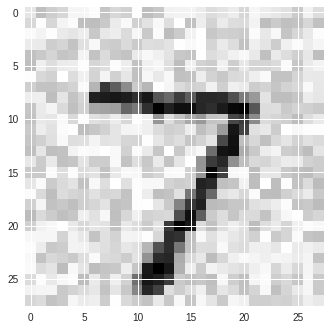

In [15]:
prediction = tf.argmax(y_pred, 1)
noise = np.squeeze(sess.run(x_noise))

def predict(idx):
    image = data.test.images[idx]
    return sess.run(prediction, feed_dict={x: [image]})

idx = 0
actual = np.argmax(data.test.labels[idx])
print ("Predicted: %d, Actual: %d" % (predict(idx), actual))
plt.imshow(data.test.images[idx].reshape((img_size,img_size)) + noise,
           cmap=plt.cm.gray_r, interpolation='nearest')

But by optimizing with `adversary_target_cls=0`, we are tuning the noise to force classification of the images as zeros.

In [16]:
optimize(n_steps, adversary_target_cls=0)

Optimization Iteration:      0, Training Accuracy:   4.0%
Optimization Iteration:     69, Training Accuracy:  14.0%
Time usage: 0:00:16


The noise displays hints of a zero, but it is mostly random.

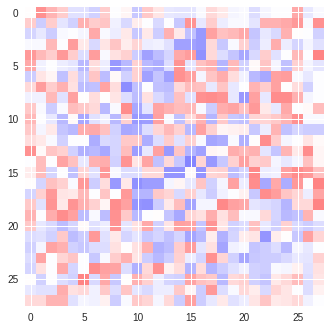

In [17]:
noise = np.squeeze(sess.run(x_noise))
plt.imshow(noise, interpolation='nearest', cmap='seismic',
           vmin=-1.0, vmax=1.0)

When it is combined with an image, our classifier is fooled.  But when we look at the image, it's still clearly a seven.

Predicted: 7, Actual: 7


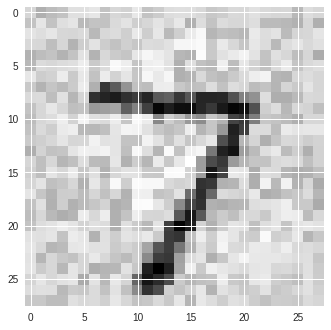

In [18]:
idx = 0
actual = np.argmax(data.test.labels[idx])
print ("Predicted: %d, Actual: %d" % (predict(idx), actual))
plt.imshow(data.test.images[idx].reshape((img_size,img_size)) + noise,
           cmap=plt.cm.gray_r, interpolation='nearest')

By optimizing without `adversary_target_cls`, we immunize the classifier against this noise.

In [19]:
optimize(n_steps)

Optimization Iteration:      0, Training Accuracy:  90.0%
Optimization Iteration:     69, Training Accuracy:  94.0%
Time usage: 0:00:12


Now the classifier works on the noisy image.

Predicted: 7, Actual: 7


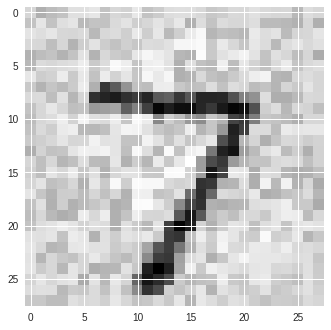

In [20]:
idx = 0
actual = np.argmax(data.test.labels[idx])
print ("Predicted: %d, Actual: %d" % (predict(idx), actual))
plt.imshow(data.test.images[idx].reshape((img_size,img_size)) + noise,
           cmap=plt.cm.gray_r, interpolation='nearest')

### Let's take a look at the graph

In [21]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [22]:
show_graph(tf.get_default_graph().as_graph_def())

## Exercise: Extending immunity

Make the network immune to all target classes. How does the accuracy of the model change?

Hint: Run `make_immune` in a for loop.

*Copyright &copy; 2017 The Data Incubator.  All rights reserved.*